<a href="https://colab.research.google.com/github/Okocha76/DS-Unit-2-Kaggle-Challenge/blob/master/module1/LS_DS10_221_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

## Assignment
- [ ] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition.
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Begin with baselines for classification.
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [1]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)

train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

## Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, what columns have zeros and shouldn't? What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)

In [0]:
import numpy as np

def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)

    # Convert to datetime and create year_recorded
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    X['year_recorded'] = X['date_recorded'].dt.year.astype(str)

    # region_code & district_code are numeric columns, but should be categorical features,
    # so convert it from a number to a string
    X['region_code'] = X['region_code'].astype(str)
    X['district_code'] = X['district_code'].astype(str)
      
            
    # quantity & quantity_group are duplicates, so drop one
    X = X.drop(columns='quantity_group')
    
    # source, source_class & source_type are almost identical. 
    # source has higher level of detail.
    X = X.drop(columns=['source_class','source_type'])

    # recorded_by has single value, so drop.
    X = X.drop(columns='recorded_by')

    # water_quality & quality_group are almost identical. 
    # water_quality has higher level of detail.
    X = X.drop(columns='quality_group')

    # waterpoint_type & waterpoint_type_group are almost identical. 
    # waterpoint_type has higher level of detail.
    X = X.drop(columns='waterpoint_type_group')

    # payment & payment_type are duplicates, so drop one
    X = X.drop(columns='payment_type')

    # extraction_type, extraction_type_class & extraction_type_group are almost identical. 
    # extraction_type has higher level of detail.
    X = X.drop(columns=['extraction_type_class','extraction_type_group'])

    # installer & funder are almost identical. 
    # funder has higher level of detail.
    X = X.drop(columns='installer')     
    
    # management & management_group are almost identical. 
    # management has higher level of detail.
    X = X.drop(columns='management_group') 

    # region_code & region are almost identical. 
    # region_code has higher level of detail.
    X = X.drop(columns='region') 

    # return the wrangled dataframe
    return X


train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [0]:
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer
# imp = IterativeImputer(max_iter=10, random_state=42)

# lat = train['latitude']
# long = train['longitude']
# reg_c = train['region_code']

# imp.fit([lat,long,reg_c])
# IterativeImputer(random_state=42)
# P_test = [[np.nan, np.nan, 2], [np.nan, np.nan, 6], [np.nan, np.nan, 16]]
# # the model learns that the second feature is double the first
# print(np.round(imp.transform(P_test)))

In [0]:
# Pandas Profiling can be very slow with medium & large datasets.
# These parameters will make it faster.
# https://github.com/pandas-profiling/pandas-profiling/issues/222

# import pandas_profiling

# profile_report = train.profile_report(
#     check_correlation_pearson=False,
#     correlations={
#         'pearson': False,
#         'spearman': False,
#         'kendall': False,
#         'phi_k': False,
#         'cramers': False,
#         'recoded': False,
#     },
#     plot={'histogram': {'bayesian_blocks_bins': False}},
# )

# profile_report

In [6]:
train.head(12)

,id,amount_tsh,date_recorded,funder,gps_height,longitude,latitude,wpt_name,num_private,basin,subvillage,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,management,payment,water_quality,quantity,source,waterpoint_type,status_group,year_recorded
43360,72938,0.0,2011-07-27,NaN,0,33.542898,-9.174777,Kwa Mzee Noa,0,Lake Nyasa,Mpandapanda,12,4,Rungwe,Kiwira,0,True,VWC,K,NaN,NaN,gravity,vwc,never pay,soft,insufficient,spring,communal standpipe,functional,2011
7263,65358,500.0,2011-03-23,Rc Church,2049,34.665760,-9.308548,Kwa Yasinta Ng'Ande,0,Rufiji,Kitichi,11,4,Njombe,Imalinyi,175,True,WUA,Tove Mtwango gravity Scheme,True,2008.0,gravity,wua,pay monthly,soft,enough,spring,communal standpipe,functional,2011
2486,469,25.0,2011-03-07,Donor,290,38.238568,-6.179919,Kwasungwini,0,Wami / Ruvu,Kwedigongo,6,1,Bagamoyo,Mbwewe,2300,True,VWC,NaN,False,2010.0,india mark ii,vwc,pay per bucket,salty,insufficient,shallow well,hand pump,functional,2011
313,1298,0.0,2011-07-31,Government Of Tanzania,0,30.716727,-1.289055,Kwajovin 2,0,Lake Victoria,Kihanga,18,1,Karagwe,Isingiro,0,True,NaN,NaN,True,NaN,other,vwc,never pay,soft,enough,shallow well,other,non functional,2011
52726,27001,0.0,2011-03-10,Water,0,35.389331,-6.399942,Chama,0,Internal,Mtakuj,1,6,Bahi,Nondwa,0,True,VWC,Zeje,True,NaN,mono,vwc,pay per bucket,soft,enough,machine dbh,communal standpipe,functional,2011
8558,41546,0.0,2011-08-07,Dwe/norad,1295,31.214583,-8.431428,Kwa Feston Mambosasa,0,Lake Tanganyika,Kisumba Kati,15,2,Sumbawanga Rural,Kasanga,200,True,VWC,Kisumba water supply,True,1986.0,gravity,vwc,never pay,soft,insufficient,river,communal standpipe,functional,2011
2559,16230,20000.0,2013-09-03,Oxfam,1515,36.696700,-3.337926,Oroirwa,0,Pangani,Oroirwa,2,2,Arusha Rural,Oltroto,150,True,VWC,Nabaiye pipe line,True,1995.0,gravity,vwc,pay monthly,soft,insufficient,spring,communal standpipe multiple,functional,2013
54735,10307,0.0,2011-04-17,Water,0,36.292724,-5.177333,Zahanati,0,Internal,Polisi,1,1,Kondoa,Mrijo,0,True,VWC,Mrij,False,NaN,mono,vwc,pay per bucket,soft,enough,machine dbh,communal standpipe,functional,2011
25763,37145,0.0,2011-08-03,Danida,0,32.877248,-8.925921,Mwambasi,0,Lake Rukwa,Bagamoyo,12,6,Mbozi,Halungu,0,False,VWC,NaN,False,NaN,swn 80,vwc,never pay,soft,enough,machine dbh,hand pump,non functional,2011
44540,49234,0.0,2011-08-03,Tancan,0,33.014412,-3.115869,Mwanzuki,0,Lake Victoria,Mwanzuki,19,7,Missungwi,Shilalo,0,True,VWC,NaN,True,NaN,submersible,vwc,pay monthly,soft,enough,machine dbh,other,non functional,2011


In [0]:
# train.dtypes

In [0]:
# import plotly.express as px
# fig = px.scatter_mapbox(train, lat='latitude', lon='longitude', color='gps_height', opacity=0.1)
# fig.update_layout(mapbox_style='carto-positron')
# fig.show()

## Baselines for classification

In [9]:
train['status_group'].value_counts(normalize=True)

functional                 0.543077
non functional             0.384238
functional needs repair    0.072685
Name: status_group, dtype: float64

## Select features.

In [10]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target & id
train_features = train.drop(columns=[target, 'id'])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features
print(features)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'population', 'construction_year', 'basin', 'region_code', 'district_code', 'public_meeting', 'scheme_management', 'permit', 'extraction_type', 'management', 'payment', 'water_quality', 'quantity', 'source', 'waterpoint_type', 'year_recorded']


In [0]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

## Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.

In [12]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    DecisionTreeClassifier(max_depth=17, random_state=42)
)

# Fit on train
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['basin', 'region_code', 'district_code',
                                     'public_meeting', 'scheme_management',
                                     'permit', 'extraction_type', 'management',
                                     'payment', 'water_quality', 'quantity',
                                     'source', 'waterpoint_type',
                                     'year_recorded'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat...
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=17, max_features=None,
                                        max_leaf_node

## Get your validation accuracy score.

In [13]:
# Score on val
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

Train Accuracy 0.8632365319865319
Validation Accuracy 0.7688552188552189


## Get and plot your feature importances.

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

model = pipeline.named_steps['decisiontreeclassifier']

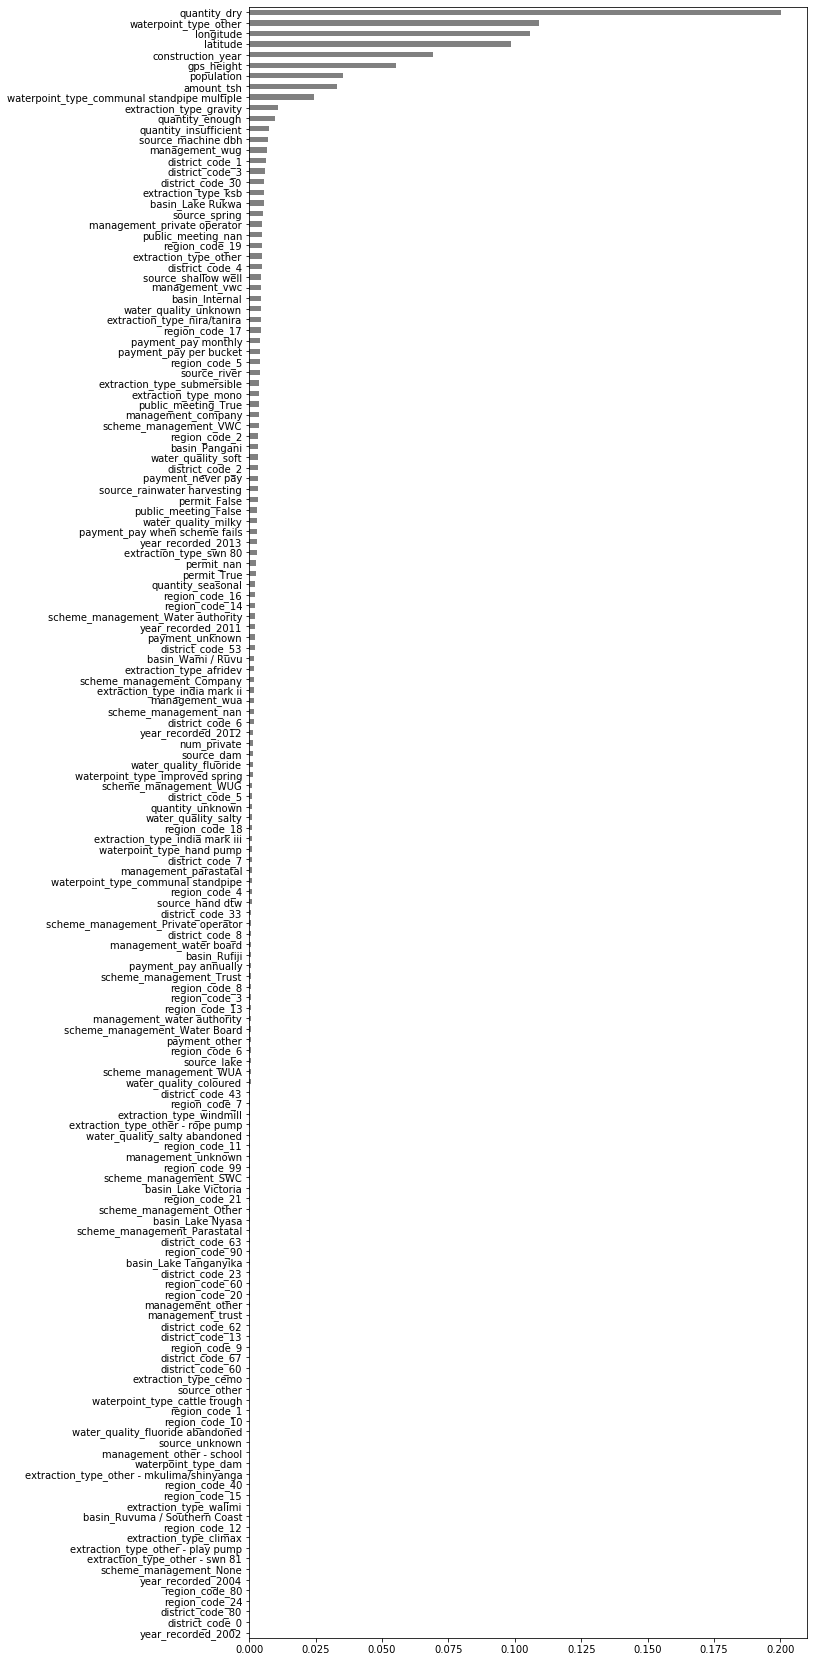

In [15]:
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='grey');

## Submit your predictions to DS10 Kaggle competition.

In [0]:
# estimator is your model or pipeline, which you've fit on X_train

# X_test is your pandas dataframe or numpy array, 
# with the same number of rows, in the same order, as test_features.csv, 
# and the same number of columns, in the same order, as X_train

y_pred = pipeline.predict(X_test)

# Makes a dataframe with two columns, id and status_group, 
# and writes to a csv file, without the index

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('your-submission-filename.csv', index=False)

In [0]:
from google.colab import files
files.download('your-submission-filename.csv')